In [1]:
!apt-get install tesseract-ocr
!pip install opencv-python-headless
!pip install pytesseract


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


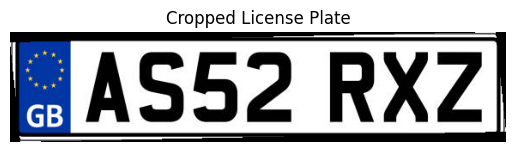

License Plate Text: = AS52 RXZ|


In [2]:
import cv2
import pytesseract
import numpy as np
from matplotlib import pyplot as plt

# Set tesseract path (necessary for Colab)
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

# Load the uploaded image
image_path = '/content/sample_data/numberplate.jpg'  # Replace with your uploaded image filename
image = cv2.imread(image_path)

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Use Canny edge detection
edges = cv2.Canny(blurred, 100, 200)

# Find contours in the edge-detected image
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort the contours based on area (largest first)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Loop over the contours and find the license plate
plate = None
for contour in contours:
    # Approximate the contour to a polygon
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # If the contour has 4 vertices, we assume it's the license plate
    if len(approx) == 4:
        plate = approx
        break

# If a license plate is found, extract the region of interest (ROI)
if plate is not None:
    # Create a mask and apply it to the original image
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [plate], -1, 255, thickness=cv2.FILLED)
    result = cv2.bitwise_and(image, image, mask=mask)

    # Crop the detected plate from the original image
    x, y, w, h = cv2.boundingRect(plate)
    cropped_plate = result[y:y+h, x:x+w]

    # Display the cropped license plate image
    plt.imshow(cv2.cvtColor(cropped_plate, cv2.COLOR_BGR2RGB))
    plt.title("Cropped License Plate")
    plt.axis('off')
    plt.show()

    # Use pytesseract to extract text from the license plate
    plate_text = pytesseract.image_to_string(cropped_plate, config='--psm 8')
    print("License Plate Text:", plate_text.strip())
else:
    print("No license plate found.")
